In [2]:
import os
import gdown
import tarfile

# Google Drive file ID (Extract from the shareable link)
file_id = "1UM5LKRipV32Kb_BQt6DUJb0VF7jx42i1"
save_path = "mvtec_ad.tar"
dataset_path = "mvtec_ad"

# Construct the direct download link
gdrive_url = f"https://drive.google.com/uc?id={file_id}"

# Download the file if not already extracted
if not os.path.exists(dataset_path):
    print("Downloading MVTec AD dataset from Google Drive...")
    gdown.download(gdrive_url, save_path, quiet=False)

    # Extract the dataset
    with tarfile.open(save_path, "r") as tar_ref:
        tar_ref.extractall(dataset_path)

    print("Download and extraction complete!")


Downloading...
From (original): https://drive.google.com/uc?id=1UM5LKRipV32Kb_BQt6DUJb0VF7jx42i1
From (redirected): https://drive.google.com/uc?id=1UM5LKRipV32Kb_BQt6DUJb0VF7jx42i1&confirm=t&uuid=7cf3b179-8302-4001-b444-9c8da4921849
To: /content/mvtec_ad.tar
100%|██████████| 156M/156M [00:03<00:00, 39.8MB/s]


Download and extraction complete!


In [3]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Resizing
import matplotlib.pyplot as plt
import glob
from skimage.metrics import structural_similarity as ssim
import seaborn as sns

# Define dataset path
category = "bottle"  # Change this to other categories like "cable"
dataset_path = f"./mvtec_ad/{category}/train/good"  # Only use normal images for training

# Get image file paths
image_paths = glob.glob(dataset_path + "/*.png")  # Adjust for JPG if needed

# Load and preprocess images
def load_images(image_paths, target_size=(28, 28)):  # Resize to match previous models
    images = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        img = cv2.resize(img, target_size)  # Resize to 28x28
        img = img.astype("float32") / 255.0  # Normalize
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        images.append(img)
    return np.array(images)

# Load training and testing data
x_train = load_images(image_paths)
x_test = load_images(glob.glob(f"./mvtec_ad/{category}/test/good/*.png"))  # Use only "good" for validation

# Print shape
print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)


Train shape: (209, 28, 28, 1)
Test shape: (20, 28, 28, 1)


In [20]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model

class ConvAutoencoder(Model):
    def __init__(self, shape):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = tf.keras.Sequential([
            Input(shape=shape),
            Conv2D(16, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same'),

            Conv2D(8, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same'),

            Conv2D(4, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same')
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),

            Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),

            Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            # UpSampling2D((2, 2)),

            Resizing(28, 28),
            Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')  # Output layer

        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
shape = x_train.shape[1:]
autoencoder = ConvAutoencoder(shape=shape)

# use ssim_loss instead
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
autoencoder.compile(optimizer='adam', loss=ssim_loss)

# compile model
# autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())



In [21]:
# Train the model
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - loss: 0.8342 - val_loss: 0.6140
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - loss: 0.5026 - val_loss: 0.4110
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.3856 - val_loss: 0.3697
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 0.3511 - val_loss: 0.3443
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - loss: 0.3308 - val_loss: 0.3226
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 0.3182 - val_loss: 0.3141
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - loss: 0.3084 - val_loss: 0.3083
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.3036 - val_loss: 0.2998
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 0.2944 - val_loss: 0.2949
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.2844 - val_loss: 0.2846
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 0.2761 - val_loss: 0.2749
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.

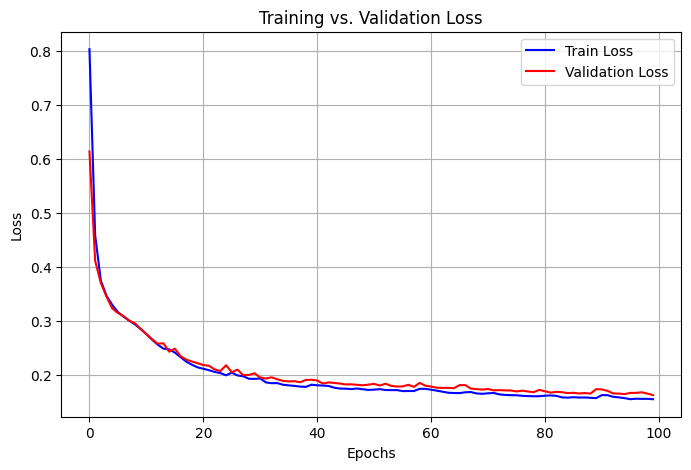

In [22]:
# plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label="Train Loss", color='blue')
plt.plot(history.history['val_loss'], label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Load some anomalous test images
anomalous_images = load_images(glob.glob(f"./mvtec_ad/{category}/test/broken_small/*.png"))

print(x_test.shape)
print(anomalous_images.shape)

(20, 28, 28, 1)
(22, 28, 28, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


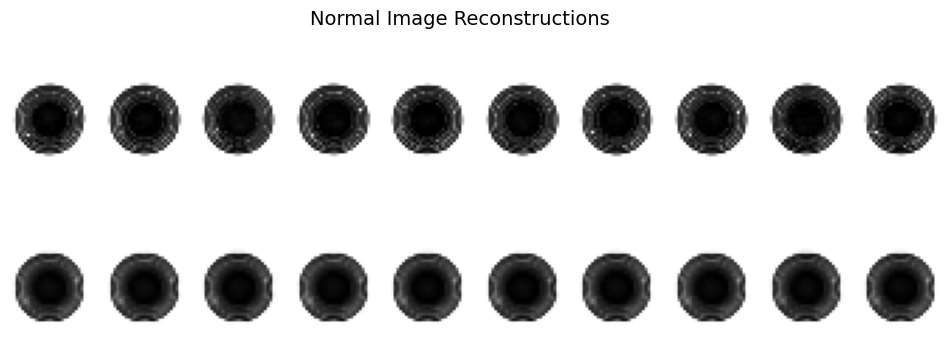

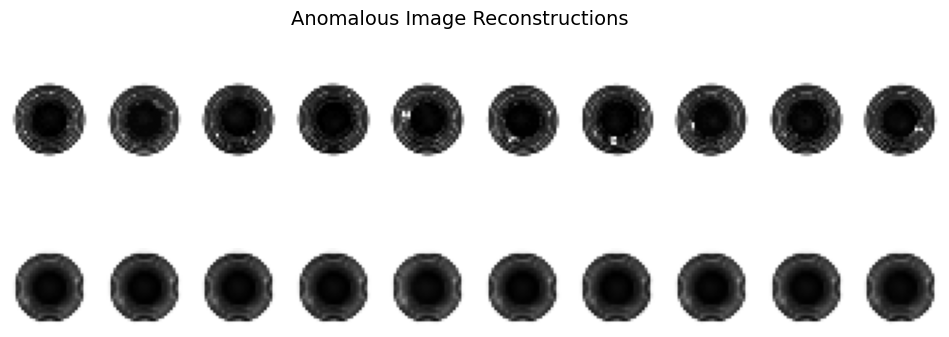

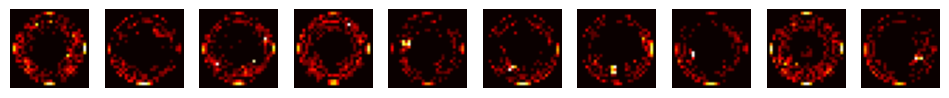

In [24]:
# reconstruct normal and anomalous images
normal_recon = autoencoder.predict(x_test[:20])  # Normal test images
anomalous_recon = autoencoder.predict(anomalous_images[:22])  # Defective images

# define function to plot results
def plot_anomaly_comparison(original, reconstructed, title):
    plt.figure(figsize=(12, 4))
    for i in range(10):
        # original image
        plt.subplot(2, 10, i + 1)
        plt.imshow(original[i].squeeze(), cmap="gray")
        plt.axis("off")

        # reconstructed image
        plt.subplot(2, 10, i + 11)
        plt.imshow(reconstructed[i].squeeze(), cmap="gray")
        plt.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()

# show normal vs reconstructed
plot_anomaly_comparison(x_test[:20], normal_recon, "Normal Image Reconstructions")

# show defective vs reconstructed
plot_anomaly_comparison(anomalous_images[:22], anomalous_recon, "Anomalous Image Reconstructions")

# plot error map
error_map = np.abs(anomalous_images[:22] - anomalous_recon)

# normalize per image
normalized_error_map = np.array([
    (error - np.min(error)) / (np.max(error) - np.min(error) + 1e-8)
    for error in error_map
])

# set treshold
threshold = 0.1
filtered_error_map = np.where(normalized_error_map > threshold, normalized_error_map, 0)

# show anomalous heatmap
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(filtered_error_map[i].squeeze(), cmap="hot")
    plt.axis("off")
plt.show()

In [30]:
import numpy as np

mse_normal = np.mean((x_test - normal_recon) ** 2, axis=(1,2,3))
mse_anomalous = np.mean((anomalous_images - anomalous_recon) ** 2, axis=(1,2,3))

print("Average MSE for normal images:", np.mean(mse_normal))
print("Average MSE for anomalous images:", np.mean(mse_anomalous))


Average MSE for normal images: 0.003953917
Average MSE for anomalous images: 0.006122458


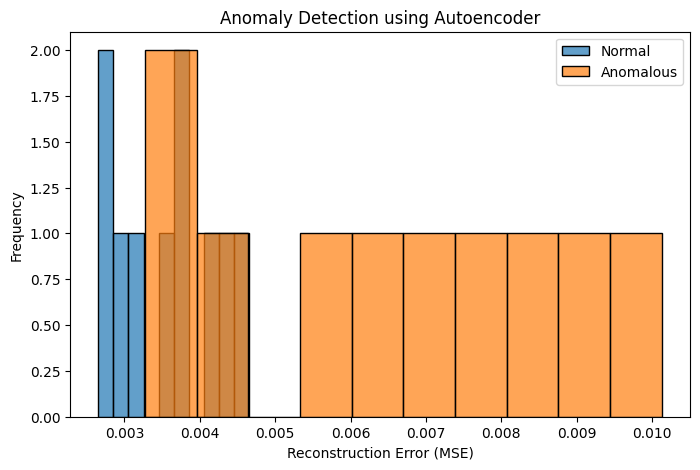

In [47]:
# visualize MSE distribution
plt.figure(figsize=(8,5))
sns.histplot(mse_normal, bins=10, alpha=0.7, label="Normal")
sns.histplot(mse_anomalous, bins=10, alpha=0.7, label="Anomalous")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.title("Anomaly Detection using Autoencoder")
plt.legend()
plt.show()

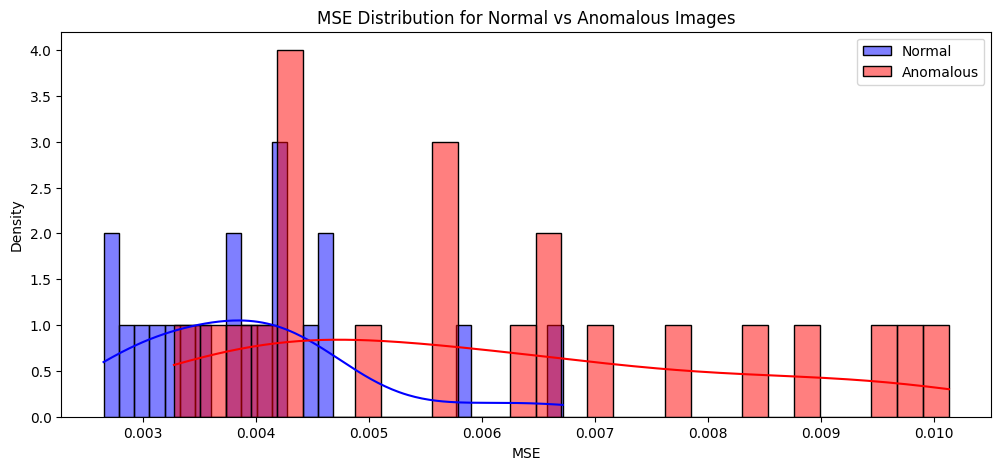

In [31]:
# plot MSE distributions
plt.figure(figsize=(12, 5))
sns.histplot(mse_normal, bins=30, color="blue", label="Normal", kde=True)
sns.histplot(mse_anomalous, bins=30, color="red", label="Anomalous", kde=True)
plt.xlabel("MSE")
plt.ylabel("Density")
plt.legend()
plt.title("MSE Distribution for Normal vs Anomalous Images")
plt.show()

In [32]:
from skimage.metrics import structural_similarity as ssim

ssim_normal = [ssim(x_test[i].squeeze(), normal_recon[i].squeeze(), data_range=1.0) for i in range(10)]
ssim_anomalous = [ssim(anomalous_images[i].squeeze(), anomalous_recon[i].squeeze(), data_range=1.0) for i in range(10)]

print("SSIM for normal images:", np.mean(ssim_normal))
print("SSIM for anomalous images:", np.mean(ssim_anomalous))

SSIM for normal images: 0.8988355001388502
SSIM for anomalous images: 0.8469036363403906


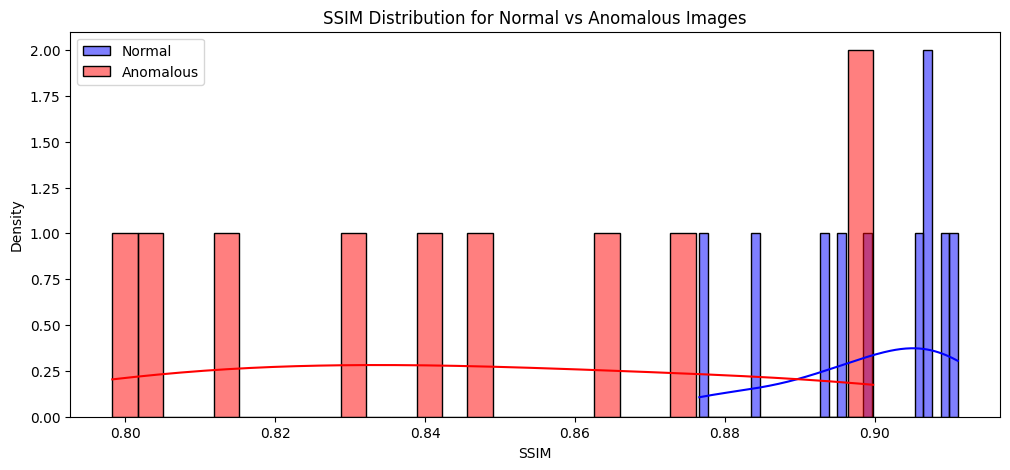

In [33]:
# plot SSIM distributions
plt.figure(figsize=(12, 5))
sns.histplot(ssim_normal, bins=30, color="blue", label="Normal", kde=True)
sns.histplot(ssim_anomalous, bins=30, color="red", label="Anomalous", kde=True)
plt.xlabel("SSIM")
plt.ylabel("Density")
plt.legend()
plt.title("SSIM Distribution for Normal vs Anomalous Images")
plt.show()

In [35]:
# set percentile thresholds (adjustable)
mse_threshold = np.percentile(mse_normal, 95)  # top 5% of normal MSE values
ssim_threshold = np.percentile(ssim_normal, 5)  #bBottom 5% of normal SSIM values

print(f"MSE Threshold: {mse_threshold}")
print(f"SSIM Threshold: {ssim_threshold}")

MSE Threshold: 0.00592801021412015
SSIM Threshold: 0.8800458185621037


In [39]:
mse_normal = np.array(mse_normal)[:10]
mse_anomalous = np.array(mse_anomalous)[:10]
ssim_normal = np.array(ssim_normal)
ssim_anomalous = np.array(ssim_anomalous)

# define anomaly score function
alpha = 0.5  # weight for SSIM
beta = 0.5   # weight for MSE

anomaly_scores_normal = alpha * (1 - ssim_normal) + beta * mse_normal
anomaly_scores_anomalous = alpha * (1 - ssim_anomalous) + beta * mse_anomalous

# compute threshold for combined anomaly score
anomaly_threshold = np.percentile(anomaly_scores_normal, 95)  # top 5% of normal scores

print(f"Anomaly Score Threshold: {anomaly_threshold}")


Anomaly Score Threshold: 0.06214263928055469


In [41]:
# classify images based on the anomaly score
normal_preds = anomaly_scores_normal > anomaly_threshold
anomalous_preds = anomaly_scores_anomalous > anomaly_threshold

# count correctly classified anomalies
true_positives = np.sum(anomalous_preds)  # anomalies detected correctly
false_negatives = len(anomalous_preds) - true_positives  # missed anomalies

# count correctly classified normal images
true_negatives = np.sum(~normal_preds)  # normal images detected correctly
false_positives = len(normal_preds) - true_negatives  # normal images wrongly classified as anomalies

# print results
print(f"True Positives (Correctly Identified Anomalies): {true_positives}")
print(f"False Negatives (Missed Anomalies): {false_negatives}")
print(f"True Negatives (Correctly Identified Normal): {true_negatives}")
print(f"False Positives (Normal Mistaken for Anomalies): {false_positives}")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

True Positives (Correctly Identified Anomalies): 8
False Negatives (Missed Anomalies): 2
True Negatives (Correctly Identified Normal): 9
False Positives (Normal Mistaken for Anomalies): 1


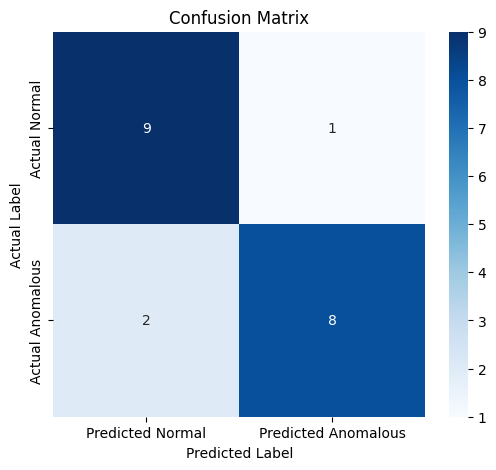

In [42]:
# create confusion matrix
conf_matrix = np.array([[true_negatives, false_positives],
                        [false_negatives, true_positives]])

# define labels
labels = ["Normal", "Anomalous"]
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Normal", "Predicted Anomalous"],
            yticklabels=["Actual Normal", "Actual Anomalous"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

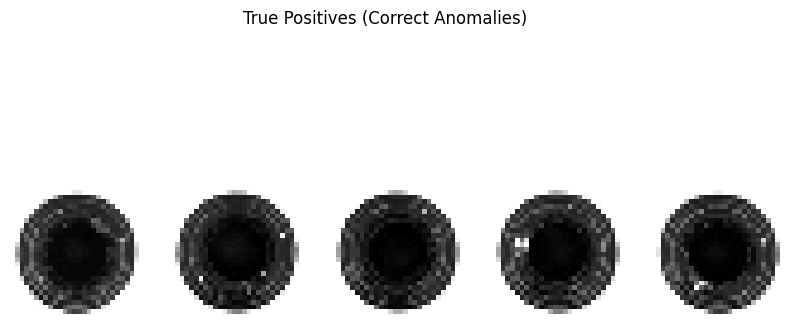

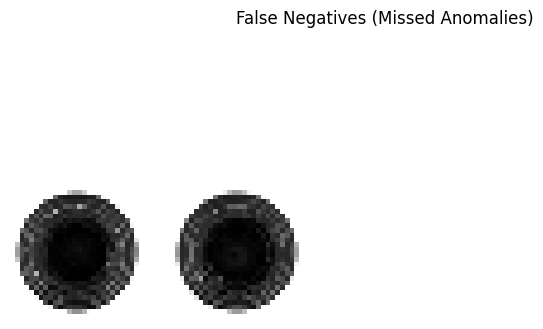

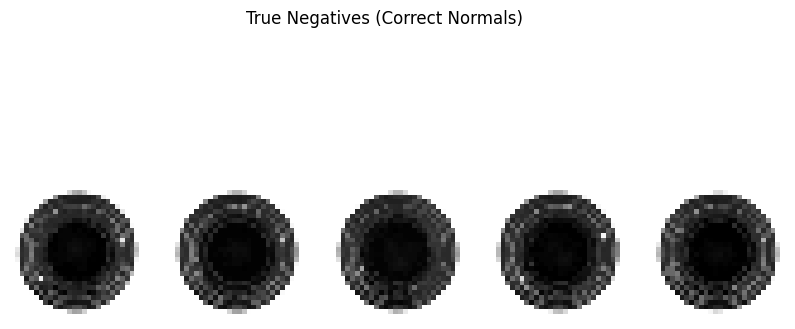

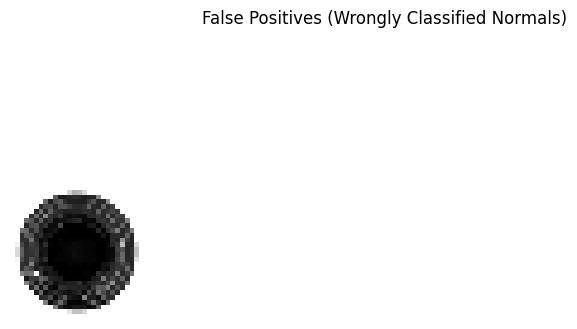

In [44]:
# get indices of classified images
true_positive_indices = np.where(anomalous_preds == True)[0]  # correctly identified anomalies
false_negative_indices = np.where(anomalous_preds == False)[0]  # missed anomalies
true_negative_indices = np.where(normal_preds == False)[0]  # correctly identified normal images
false_positive_indices = np.where(normal_preds == True)[0]  # normal images mistakenly classified as anomalies

# helper function to plot images
def plot_images(indices, dataset, title, num_images=5):
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices[:num_images]):  # show only the first `num_images`
        plt.subplot(1, num_images, i + 1)
        plt.imshow(dataset[idx].squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# show correctly identified anomalies
plot_images(true_positive_indices, anomalous_images, "True Positives (Correct Anomalies)")

# show missed anomalies
plot_images(false_negative_indices, anomalous_images, "False Negatives (Missed Anomalies)")

# show correctly identified normal images
plot_images(true_negative_indices, x_test, "True Negatives (Correct Normals)")

# show normal images mistakenly classified as anomalies
plot_images(false_positive_indices, x_test, "False Positives (Wrongly Classified Normals)")